Need plots of the following:

1. There are just few enough spectra that I think that we can get away with showing all of them in an appendix.  See if you can put together stacks of 10 (like the stack of 2 attached) that show the ICA reconstruction overplotted on the SDSS spectrum.  We can arrange them in 2.5 columns of 2 in order to display all 50.


2. Let's create a plot (that can be included in the paper as opposed to easily viewed online) of all the radio detections.  Maybe a grid with all 22 in the same figure?  Maybe split into multiple figures? 


3. Some kind of figure that ties together the CIV "distance" with the radio (but that is static, not Bokeh and doesn't involve the tSNE projections).  [I think that we might still need/want the tSNE stuff, but there's no reason that we can't keep it simpler for now.]


4. Histogram of radio fluxes (and limits).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.cosmology import FlatLambdaCDM
import richardsplot
%matplotlib inline

In [2]:
#Use this cosmology throughout
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [3]:
#Equations
def radluminosity(nu1, nu2, S, alpha, z):
    #calculate luminosity at nu1 based on data at nu2
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    L = ((4*np.pi*DL**2*(S*1e-23*1e-6)) / ((1+z)**(1+alpha))) * (nu1/nu2)**alpha * 1e-7
    return np.log10(L)

def Slim(nu1, nu2, L1, alpha, z):
    #Given luminosity at nu1, compute corresponding flux at nu2 - just inversion of above equation
    DL = 3.086e24 * cosmo.luminosity_distance(z).value #cm
    S = (((1+z)**(1+alpha))/(4*np.pi*DL**2)) * (nu2/nu1)**alpha * L1*1e23*1e7*1e6 #return in µJy
    return S
    
def rich2006(Mi):
    #compute 2500Å luminosity using eq. 4 from QLF paper Richards et al. (2006)
    d = 3.08e19 #cm == 10pc
    L2500 = 4*np.pi*d**2 * 10**(-0.4*(Mi+48.6+2.5*np.log10(1+2)))
    return np.log10(L2500) - 7 #return log in W/Hz
    
def SFR_L14(L14):
    #Yun+2001 SFR relation based on 1.4GHz luminosity
    return 5.9e-22 * (10**L14)

def SFR_Mi(Mi):
    #Absolute magnitude SFR relation from Harris+2016
    return -29*Mi**2 - 1625*Mi - 22505

def SFR_eqw(E):
    #Equation 8 of Harris+2016 - compute SFR given EQW measurements
    return 4205*E**(-.5) - 328

In [4]:
df = pd.read_csv('../SpringFinalFigs_moreParams.csv')

pf = df[["peak_flux"]].values.flatten() #peak fluxes and upper-limits in µJy
intf = df[["int_flux"]].values.flatten() #measured int. fluxes - really only important for FIRST source
z = df[["redshift_1"]].values.flatten() #redshifts from Hewett & Wild
DL = 3.086e24*cosmo.luminosity_distance(z).value #luminosity distances in cm - save these

L3 = radluminosity(3., 3., pf, -0.7, z) #K-corrected 3GHz luminosities
ND = (df[["detection"]].values.flatten() + df[["FIRST"]].values.flatten())==0 #mask non-detections - easy this way for plots
D = (df[["detection"]].values.flatten() + df[["FIRST"]].values.flatten())==1 #mask detections
F = (df[["detection"]].values.flatten() + df[["FIRST"]].values.flatten())==2 #mask FIRST sources
print(L3[F])
L3[F] = radluminosity(3., 1.4, intf[F], -0.7, z[F]) #recompute FIRST luminosities based on their flux measurements being at 1.4GHz, not 3GHz
print(L3[F])

#Compute 1.4GHz luminosities for Yun+01 SFR relation
L14_gtr = radluminosity(1.4, 3., pf, -0.7, z)
L14_gtr[F] = radluminosity(1.4, 1.4, intf[F], -0.7, z[F])

Miz2 = df[["MIZ2"]].values.flatten()
eqw = df[["ICA_CIV_EQW"]].values.flatten()
L2500 = rich2006(Miz2)

df["Luminosity distance (cm)"] = DL
df["L_3GHz (W/Hz)"] = L3
df["L_1.4GHz (W/Hz)"] = L14_gtr
df["L_2500A (W/Hz)"] = L2500


#Amy's sample
df2 = pd.read_csv("../RQQfigs.csv")
f6 = df2[["Flux"]].values.flatten()
det = df2[["Detection"]].values.flatten()==1
z_amy = df2[["z"]].values.flatten()
LD_amy = 3.086e24*cosmo.luminosity_distance(z_amy).value
L14_amy = radluminosity(1.4, 6., f6, -0.7, z_amy)
L6_amy = radluminosity(6., 6., f6, -0.7, z_amy)

#Kellerman data
df3 = pd.read_csv("../KellermanQSOs.csv")
f6kell = df3[["S(6)_t"]].values.flatten()
z_kell = df3[["z"]].values.flatten()
LD_kell = 3.086e24*cosmo.luminosity_distance(z_kell).value
L14_kell = radluminosity(1.4, 6., f6kell, -0.7, z_kell)
L6_kell = radluminosity(6., 6., f6kell, -0.7, z_kell)


[25.53944198 26.83321706]
[25.30774672 26.64805138]


---
### Radio distributions of our 50 targets

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


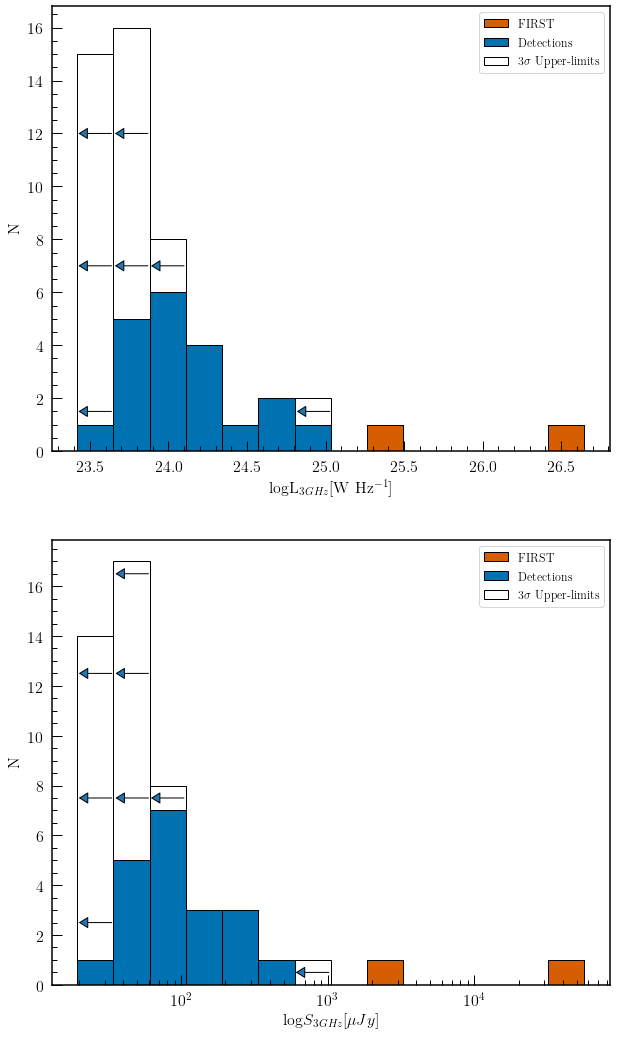

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(10,18))
Lbins = np.linspace(min(L3), max(L3), 15)
Sbins = np.logspace(np.log10(min(pf)), np.log10(max(intf)), 15)

ax[0].hist([L3[F], L3[D], L3[ND]], histtype="barstacked", color=["#d55e00", "#0072b2", "w"],
          edgecolor="k", bins=Lbins, label=["FIRST", "Detections", "3$\sigma$ Upper-limits"])

#Upper limit symbols
ax[0].annotate('', xy=(23.65, 1.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax[0].annotate('', xy=(23.65, 7), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax[0].annotate('', xy=(23.65, 12), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax[0].annotate('', xy=(23.882, 7), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax[0].annotate('', xy=(23.882, 12), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax[0].annotate('', xy=(24.112, 7), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax[0].annotate('', xy=(25.04, 1.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax[0].set_xlabel("logL$_{3GHz}$[W Hz$^{-1}$]")
ax[0].set_ylabel("N")
ax[0].legend(loc="best")


ax[1].hist([intf[F], pf[D], pf[ND]], histtype="barstacked", color=["#d55e00", "#0072b2", "w"],
          edgecolor="k", bins=Sbins, label=["FIRST", "Detections", "3$\sigma$ Upper-limits"])


#Upper limit symbols
ax[1].annotate('', xy=(10**1.54, 2.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax[1].annotate('', xy=(10**1.54, 7.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax[1].annotate('', xy=(10**1.54, 12.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax[1].annotate('', xy=(10**1.79, 7.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax[1].annotate('', xy=(10**1.79, 12.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax[1].annotate('', xy=(10**1.79, 16.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax[1].annotate('', xy=(10**2.032, 7.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax[1].annotate('', xy=(10**3.02, 0.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))




ax[1].set_xscale("log")
ax[1].set_xlabel("log$S_{3GHz}[\\mu Jy$]")
ax[1].set_ylabel("N")
ax[1].legend(loc="best")

Basic histogram of luminosities.  What is current listed a an L~25 upper-limit should be removed from our sample due to significant imaging troubles.  Both FIRST sources have been corrected to 3GHz from their 1.4GHz data assuming $\alpha=-0.7$.  

7/27/20: Still need to re-run this once TM finishes fluxes with ``imfit``

7/28/20: Done.  Although do we want to set integrated flux = peak flux for the sources which are clearly not extended?  (This was done in Kellerman+ 2016 and might make sense for us as the int. flux measurements don't seem to agree with peak flux in instances where they should.)

7/29/20: We all agreed to take the peak flux measurement for unresolved sources.  This change is reflected in the current version of plots

-----

### SFR Harris/Yun relations

  * Take the computed L1.4 to compute SFRs for both Amy and Gordon's samples using equation 13 from Yun et al. 2001
    * $$ SFR [M_{sun}/yr] = (5.9±1.8) * 10^{-22}L_{1.4GHz}[W/Hz] $$
  
  
  
  
  
  * Use DR7 magnitudes $M_i(z=2)$ to compute SFR from equation 2 of Harris et al. 2016
    * $$ SFR [M_{sun}/yr] = -(29±16)M_i^2 - (1625±825)M_i - (22505±10244) $$
  
  
  
  
  
  * Use our ICA CIV EQW ($E_C$) to compute SFR from equation 8 of Harris et al. 2016
    * $$ SFR [M_{sun}/yr] = (4205±651)E_C^{-0.5} - (328±98) $$

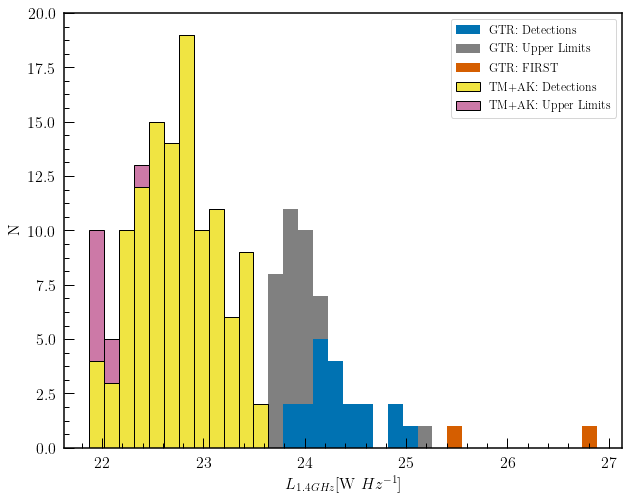

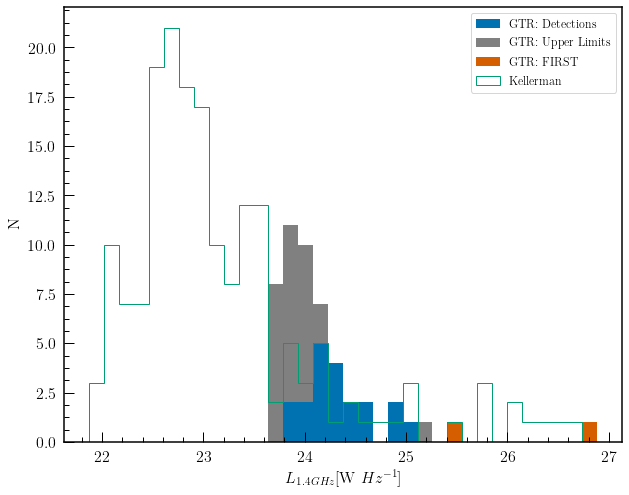

In [6]:
fig = plt.figure(figsize=(10,8))
bins1 = np.linspace((min(L14_amy)), (max(L14_gtr)), 35)

plt.hist([L14_gtr[D], L14_gtr[ND], L14_gtr[F]], histtype="barstacked", color=["#0072b2", "grey", "#d55e00"], 
         edgecolor="None", bins=bins1, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])
plt.hist([L14_amy[det], L14_amy[~det]], histtype="barstacked", color=["#f0e442", "#cc79a7"], bins=bins1, 
         edgecolor="k", label=["TM+AK: Detections", "TM+AK: Upper Limits"])

plt.xlabel("$L_{1.4GHz}$[W $Hz^{-1}$]")
plt.ylabel("N")
plt.ylim(0,20)
plt.legend(loc="best")
plt.show()


fig2 = plt.figure(figsize=(10,8))

plt.hist([L14_gtr[D], L14_gtr[ND], L14_gtr[F]], histtype="barstacked", color=["#0072b2", "grey", "#d55e00"], 
         edgecolor="None", bins=bins1, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])

plt.hist([L14_kell], histtype="step", color="#009e73", bins=bins1, label=["Kellerman"])

plt.xlabel("$L_{1.4GHz}$[W $Hz^{-1}$]")
plt.ylabel("N")
plt.legend(loc="best")
plt.show()

Now want to use Yun+2001 to see what SFRs these 1.4 GHz luminosities correspond to 

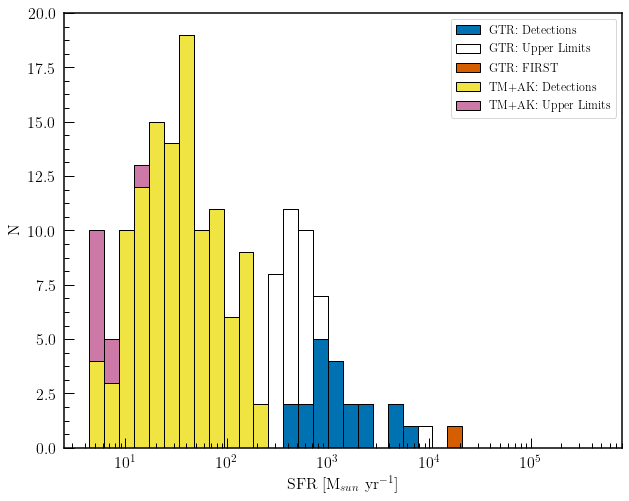

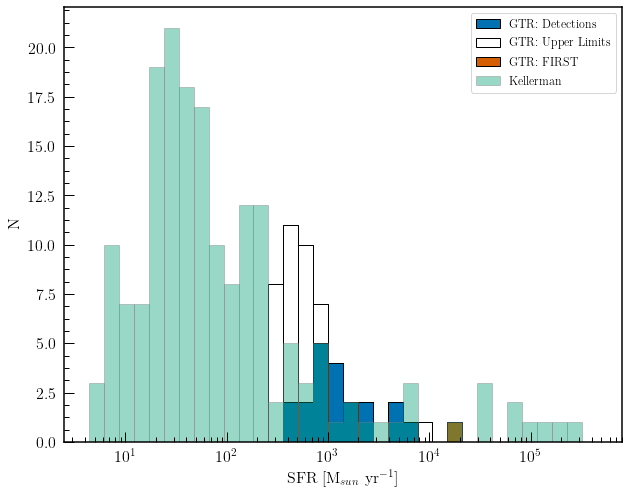

Star formation predictions by Yun et al. 2001:
GTR   median SFR: 589.54 Msun/yr
AK+TM median SFR: 28.65 Msun/yr
Kell  median SFR: 49.67 Msun/yr


In [7]:
fig = plt.figure(figsize=(10,8))
bins2 = np.logspace(np.log10(min(SFR_L14(L14_amy))), np.log10(max(SFR_L14(L14_gtr))), 35)

plt.hist([SFR_L14(L14_gtr[D]), SFR_L14(L14_gtr[ND]), SFR_L14(L14_gtr[F])], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
         edgecolor="k", bins=bins2, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])
plt.hist([SFR_L14(L14_amy[det]), SFR_L14(L14_amy[~det])], histtype="barstacked", color=["#f0e442", "#cc79a7"], 
         edgecolor="k", bins=bins2, label=["TM+AK: Detections", "TM+AK: Upper Limits"])

plt.xlabel("SFR [M$_{sun}$ yr$^{-1}$]")
plt.ylabel("N")
plt.xscale("log")
plt.ylim(0,20)
plt.legend(loc="best")
plt.show()


fig2 = plt.figure(figsize=(10,8))

plt.hist([SFR_L14(L14_gtr[D]), SFR_L14(L14_gtr[ND]), SFR_L14(L14_gtr[F])], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
         edgecolor="k", bins=bins2, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])

plt.hist(SFR_L14(L14_kell), histtype="barstacked", color="#009e73", label="Kellerman",
          alpha=0.4, bins=bins2, edgecolor="grey")

plt.xlabel("SFR [M$_{sun}$ yr$^{-1}$]")
plt.ylabel("N")
plt.xscale("log")
plt.legend(loc="best")
plt.show()


print("Star formation predictions by Yun et al. 2001:")
print("GTR   median SFR: %.2f Msun/yr" % (np.median(SFR_L14(L14_gtr))))
print("AK+TM median SFR: %.2f Msun/yr" % (np.median(SFR_L14(L14_amy))))
print("Kell  median SFR: %.2f Msun/yr" % (np.median(SFR_L14(L14_kell))))

How do these compare to the SFRs predicted by Harris+2016?

Star formation predictions by Harris et al. 2016:
GTR median SFR (Mi) : 202.33 Msun/yr
GTR median SFR (EQW): 76.73 Msun/yr


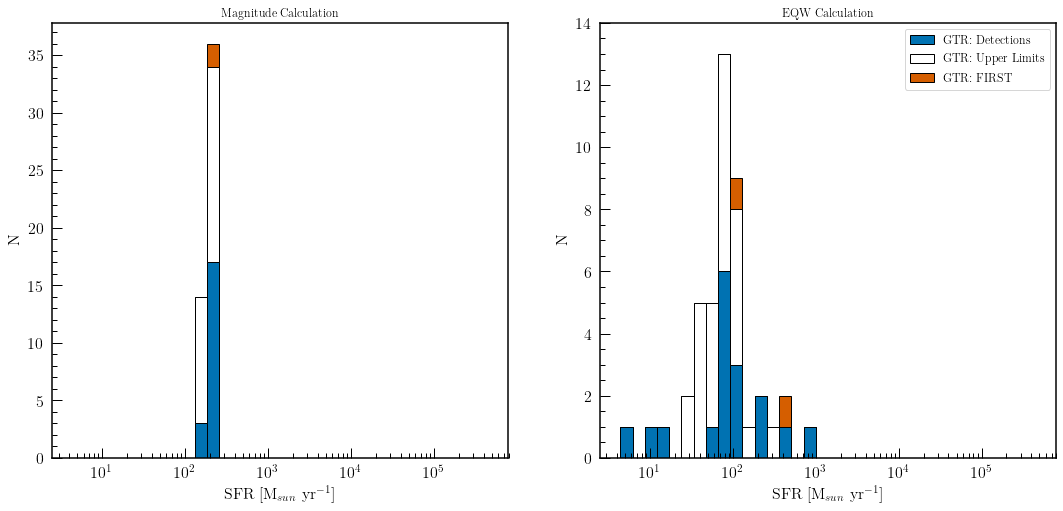

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18,8))

ax[0].hist([SFR_Mi(Miz2[D]), SFR_Mi(Miz2[ND]), SFR_Mi(Miz2[F])], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
         edgecolor="k", bins=bins2, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])
ax[0].set_xscale("log")
ax[0].set_title("Magnitude Calculation")
ax[0].set_xlabel("SFR [M$_{sun}$ yr$^{-1}$]")
ax[0].set_ylabel("N")

ax[1].hist([SFR_eqw(eqw[D]), SFR_eqw(eqw[ND]), SFR_eqw(eqw[F])], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
         edgecolor="k", bins=bins2, label=["GTR: Detections", "GTR: Upper Limits", "GTR: FIRST"])
ax[1].set_xscale("log")
ax[1].set_title("EQW Calculation")
ax[1].set_xlabel("SFR [M$_{sun}$ yr$^{-1}$]")
ax[1].set_ylabel("N")
ax[1].legend(loc="best")
ax[1].set_ylim(0,14)

print("Star formation predictions by Harris et al. 2016:")
print("GTR median SFR (Mi) : %.2f Msun/yr" % (np.median(SFR_Mi(Miz2))))
print("GTR median SFR (EQW): %.2f Msun/yr" % (np.median(SFR_eqw(eqw))))

Visualize how SFR actually varies with these three quantities: 
* L$_{1.4GHz}$,   
* M$_i(z=2)$ and 
* EQW

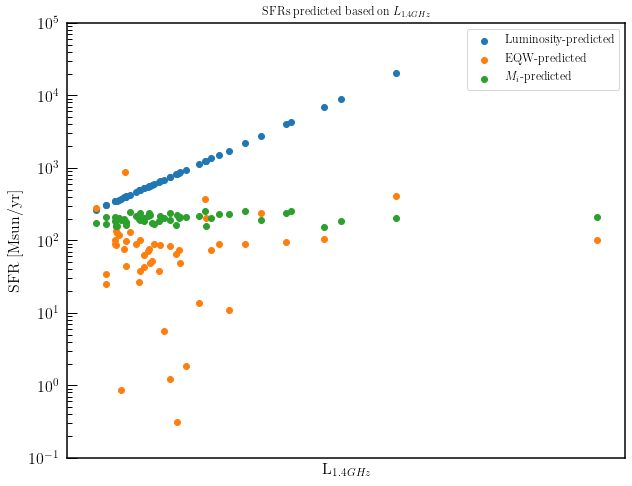

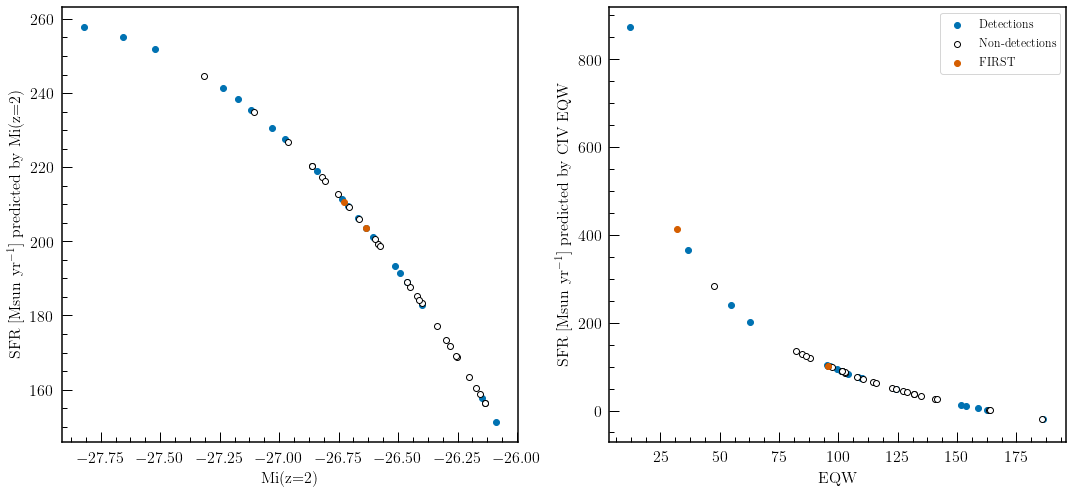

In [9]:
fig1 = plt.figure(figsize=(10,8))
plt.scatter(L14_gtr, SFR_L14(L14_gtr), label="Luminosity-predicted")
plt.scatter(L14_gtr, SFR_eqw(eqw), label="EQW-predicted")
plt.scatter(L14_gtr, SFR_Mi(Miz2), label="$M_{i}$-predicted")
plt.xscale("log")
plt.yscale("log")
plt.ylim(0.1, 10**5)
plt.xlabel("L$_{1.4GHz}$")
plt.ylabel("SFR [Msun/yr]")
plt.title("SFRs predicted based on $L_{1.4GHz}$")
plt.legend(loc="best")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(18,8))

ax[0].scatter(Miz2[D], SFR_Mi(Miz2[D]), color="#0072b2", label="Detections")
ax[0].scatter(Miz2[ND], SFR_Mi(Miz2[ND]), color="w", edgecolor="k", label="Non-detections")
ax[0].scatter(Miz2[F], SFR_Mi(Miz2[F]), color="#d55e00", label="FIRST")

ax[0].set_xlabel("Mi(z=2)")
ax[0].set_ylabel("SFR [Msun yr$^{-1}$] predicted by Mi(z=2)")

ax[1].scatter(eqw[D], SFR_eqw(eqw[D]), color="#0072b2", label="Detections")
ax[1].scatter(eqw[ND], SFR_eqw(eqw[ND]), color="w", edgecolor="k", label="Non-detections")
ax[1].scatter(eqw[F], SFR_eqw(eqw[F]), color="#d55e00", label="FIRST")

ax[1].set_xlabel("EQW")
ax[1].set_ylabel("SFR [Msun yr$^{-1}$] predicted by CIV EQW")
#ax[1].set_xscale("log")
ax[1].legend(loc="best")
plt.show()

We can now ask: given these SFRs, what 1.4 GHz luminosity does Yun+2001 predict based on the EQW/Mi relations and how to those predictions compare with our "measured" 1.4 GHz luminosities?

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


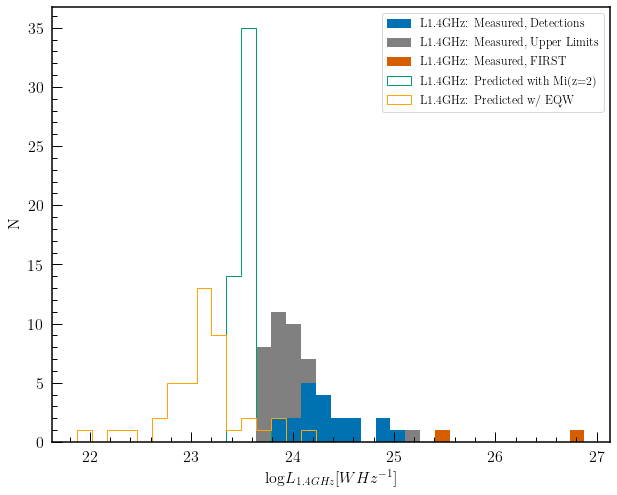

In [10]:
#Use Yun+2001 to invert these SFRs to L1.4GHz
L14_eqw = np.log10(1.7e21*SFR_eqw(eqw))
L14_Mi = np.log10(1.7e21*SFR_Mi(Miz2))

fig = plt.figure(figsize=(10,8))

plt.hist([L14_gtr[D], L14_gtr[ND], L14_gtr[F]], histtype="barstacked", color=["#0072b2", "grey", "#d55e00"], 
         edgecolor="None", bins=bins1, label=["L1.4GHz: Measured, Detections", "L1.4GHz: Measured, Upper Limits", "L1.4GHz: Measured, FIRST"])
plt.hist([L14_eqw, L14_Mi], histtype="step", bins=bins1, color=["#ffa500", "#009e73"],
          label=["L1.4GHz: Predicted w/ EQW", "L1.4GHz: Predicted with Mi(z=2)"])

#plt.xscale("log")
plt.xlabel("log$L_{1.4GHz} [W Hz^{-1}]$")
plt.ylabel("N")
plt.legend(loc="best")
plt.show()

So the radio luminosity predicted by each SF relation undershoots even our faintest detections by nearly an order of magnitude

---

### Compute SFRs and necessary flux limits to reach luminosities predicted by Yun+2001

In [11]:
#Define median Harris SFRs
eqwSFR = np.median(SFR_eqw(eqw)) #median SFR predicted from EQW relation in Harris+2016
MiSFR = np.median(SFR_Mi(Miz2))    #median SFR predicted from Mi relation in Harris+2017

#Reverse-engineer Yun+01 to compute theoretical luminosity predicted by SFR calculations
L_eqwSFR_14 = 1.7e21 * eqwSFR #W/Hz
L_MiSFR_14 = 1.7e21 * MiSFR #W/Hz

#Convert this luminosity  
Slim_eqw = Slim(1.4, 3., L_eqwSFR_14, -0.7, 1.65) #µJy
L_eqw = radluminosity(3., 3., Slim_eqw, -0.7, 1.65) #W/Hz; median L3GHz predicted by EQW SFR
Slim_Mi = Slim(1.4, 3., L_MiSFR_14, -0.7, 1.65) #µJy
L_Mi = radluminosity(3., 3., Slim_Mi, -0.7, 1.65) #W/Hz; median L3GHz predicted by Mi


print("EQW relation from Harris+16 tells us our median SFR is %.2f Msol/yr" % eqwSFR)
print("Coupling this with Yun+01, this corresponds to log(L3[W/Hz]) ~ %.2f" % (L_eqw))
print("This gives a spectral flux density of ~ %.2f muJy/b" % (Slim_eqw))
print("A 3-sigma detection then corresponds to noise levels ~ %.2fmuJy/b\n" % (Slim_eqw/3))

print("Mi relation from Harris+16 tells us our median SFR is %.2f Msol/yr" % MiSFR)
print("Coupling this with Yun+01, this corresponds to log(L3[W/Hz]) ~ %.2f" % (L_Mi))
print("This gives a spectral flux density of ~ %.2f muJy/b" % Slim_Mi)
print("A 3-sigma detection then corresponds to noise levels ~ %.2fmuJy/b\n" % (Slim_Mi/3))



#Now we ask: if we wanted to go with the overall median SFR for z~2 galaxies from 
#Harris+2016 (~300±100 Msun/yr) what noise levels would we need to detect this 
#radio emission at both 300 and the upper bound?

L_medSFR_14 = 1.7e21 * 300 #median 1.4GHz luminosity due to SF from Harris+2016
Slim_med = Slim(1.4, 3., L_medSFR_14, -0.7, 1.65) #µJy
L_med = radluminosity(3., 3., Slim_med, -0.7, 1.65) #W/Hz; median L3GHz predicted by Mi

print("For z~2, Harris+16 tells us the median SFR is %.2f Msol/yr" % 300.)
print("Coupling this with Yun+01, this corresponds to log(L3[W/Hz]) ~ %.2f" % (L_med))
print("This gives a spectral flux density of ~ %.2f muJy/b" % Slim_med)
print("A 3-sigma detection then corresponds to noise levels ~ %.2fmuJy/b\n" % (Slim_med/3))



L_upSFR_14 = 1.7e21 * 400 #upper-bound median 1.4GHz luminosity due to SF from Harris+2016
Slim_up = Slim(1.4, 3., L_upSFR_14, -0.7, 1.65) #µJy
L_up = radluminosity(3., 3., Slim_up, -0.7, 1.65) #W/Hz; median L3GHz predicted by Mi

print("For z~2, Harris+16 tells us the upper-bound median SFR is %.2f Msol/yr" % 400.)
print("Coupling this with Yun+01, this corresponds to log(L3[W/Hz]) ~ %.2f" % (L_up))
print("This gives a spectral flux density of ~ %.2f muJy/b" % Slim_up)
print("A 3-sigma detection then corresponds to noise levels ~ %.2fmuJy/b" % (Slim_up/3))

EQW relation from Harris+16 tells us our median SFR is 76.73 Msol/yr
Coupling this with Yun+01, this corresponds to log(L3[W/Hz]) ~ 22.88
This gives a spectral flux density of ~ 5.69 muJy/b
A 3-sigma detection then corresponds to noise levels ~ 1.90muJy/b

Mi relation from Harris+16 tells us our median SFR is 202.33 Msol/yr
Coupling this with Yun+01, this corresponds to log(L3[W/Hz]) ~ 23.30
This gives a spectral flux density of ~ 15.00 muJy/b
A 3-sigma detection then corresponds to noise levels ~ 5.00muJy/b

For z~2, Harris+16 tells us the median SFR is 300.00 Msol/yr
Coupling this with Yun+01, this corresponds to log(L3[W/Hz]) ~ 23.48
This gives a spectral flux density of ~ 22.24 muJy/b
A 3-sigma detection then corresponds to noise levels ~ 7.41muJy/b

For z~2, Harris+16 tells us the upper-bound median SFR is 400.00 Msol/yr
Coupling this with Yun+01, this corresponds to log(L3[W/Hz]) ~ 23.60
This gives a spectral flux density of ~ 29.65 muJy/b
A 3-sigma detection then corresponds to 